# Dati Coronavirus Italia

In [43]:
import locale
import sys, getopt
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib

In [44]:
# Config

url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
days_range = 45
order = 4
log_scale = True

# Implementation

tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
data = pd.read_csv(url)
data.data = pd.to_datetime(data.data)
data['nuovi_decessi'] = data.deceduti.diff()
data['mortalita'] = data.deceduti / data.totale_casi
data['guariti'] = data.dimessi_guariti / data.totale_casi
data['ricoverati'] = data.totale_ospedalizzati / data.totale_casi
data['intensivi'] = data.terapia_intensiva / data.totale_casi
data_pct = data[data.columns.difference(['data','stato','note_it','note_en'])].pct_change()
data_pct.insert(0,'data', data.data)
updated_at = data.data.iloc[-1].strftime('%d/%m/%Y')
locale.setlocale(locale.LC_ALL, 'it_IT.utf-8')

def thousands(value):
  return f'{value:,}'

def fmt_plot(aplot, size):
  global log_scale

  aplot.grid(which='major', color='#999999', linestyle='--')
  aplot.grid(which='minor', color='#CCCCCC', linestyle=':')
  aplot.set(xlabel="Giorni dal 24/02/2020")
  aplot.yaxis.set_major_formatter(tick)
  aplot.xaxis.set_major_locator(MultipleLocator(5))
  aplot.xaxis.set_minor_locator(AutoMinorLocator(5))
  if log_scale:
    return aplot
  aplot.yaxis.set_major_locator(MultipleLocator(size))
  aplot.yaxis.set_minor_locator(AutoMinorLocator(5))
  return aplot

def print_last_result(label, column):
  global data
  global data_pct
  last = data[column].iloc[-1]
  pct_var = data_pct[column].iloc[-1]
  tabs = '\t' if last >= 100000 else '\t\t'
  print(label, thousands(last), end='\t')
  print(f' {tabs}( {pct_var:+.2%} )')

def print_pct(label, column):
  pct = data[column].iloc[-1]
  pct_pct = data_pct[column].iloc[-1]
  tabs = '\t\t\t' if pct <= 0.1 else '\t\t'
  print(label, f'{pct:.2%}', end='')
  print(f' {tabs}( {pct_pct:+.2%} )')


In [45]:
# Data model:
#   'data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
#   'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
#   'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
#   'deceduti', 'totale_casi', 'tamponi', 'note_it', 'note_en'

print("Aggiornamento: ", updated_at, "\t\tvariazione rispetto a ieri")
print("------------------------------------------------------------------")
print_last_result("Totale casi: \t\t", 'totale_casi')
print_last_result("Totale nuovi casi: \t", 'nuovi_positivi')
print_last_result("Variazione nuovi casi: \t", 'variazione_totale_positivi')
print_last_result("Totale decessi: \t", 'deceduti')
print_last_result("Variazione decessi: \t", 'nuovi_decessi')
print_last_result("Terapia intensiva: \t", 'terapia_intensiva')
print_last_result("Ospedalizzati: \t\t", 'totale_ospedalizzati')
print_last_result("Dimessi: \t\t", 'dimessi_guariti')
print_last_result("Totale tamponi: \t", 'tamponi')
print()
print_pct("Mortalità: \t\t", 'mortalita')
print_pct("Critici: \t\t", 'intensivi')
print_pct("Ricoverati: \t\t", 'ricoverati')
print_pct("Guariti: \t\t", 'guariti')


Aggiornamento:  04/04/2020 		variazione rispetto a ieri
------------------------------------------------------------------
Totale casi: 		 124,632	 	( +4.01% )
Totale nuovi casi: 	 4,805	 		( +4.80% )
Variazione nuovi casi: 	 2,886	 		( +23.39% )
Totale decessi: 	 15,362	 		( +4.64% )
Variazione decessi: 	 681.0	 		( -11.10% )
Terapia intensiva: 	 3,994	 		( -1.82% )
Ospedalizzati: 		 33,004	 		( +0.59% )
Dimessi: 		 20,996	 		( +6.27% )
Totale tamponi: 	 657,224	 	( +6.03% )

Mortalità: 		 12.33% 		( +0.60% )
Critici: 		 3.20% 			( -5.60% )
Ricoverati: 		 26.48% 		( -3.28% )
Guariti: 		 16.85% 		( +2.17% )


## Grafici andamenti (scala logaritmica)

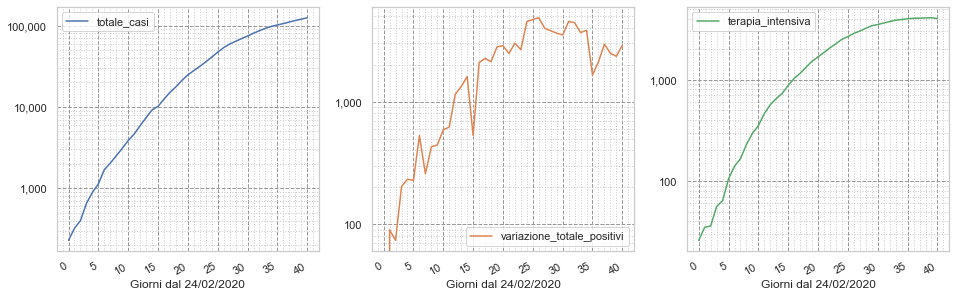

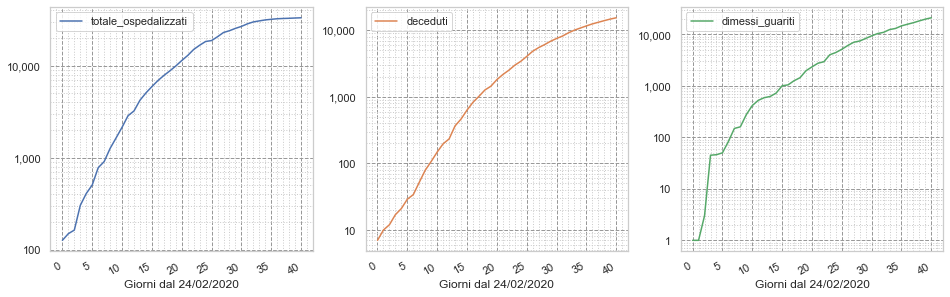

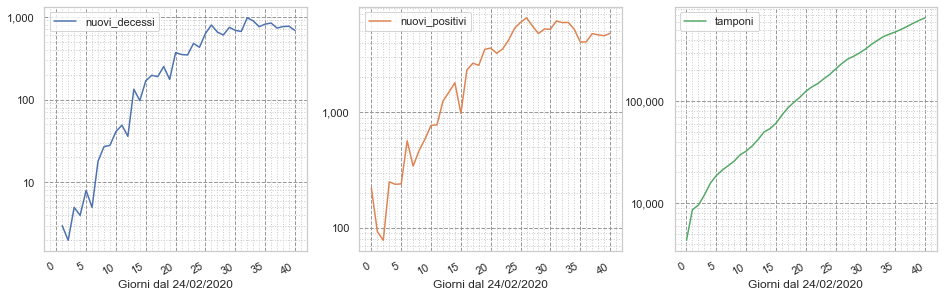

In [46]:
plt.rcParams['figure.figsize'] = [16, 5]
sns.set(style='whitegrid')

def plot_func(columns):
    global log_scale
    return data.loc[:,columns] \
        .plot(kind='line',
            subplots=True,
            sharex=True,
            layout=(1,3),
            grid=True,
            legend=True,
            logy=log_scale)

plots = plot_func(['totale_casi','variazione_totale_positivi','terapia_intensiva'])
plt_casi = fmt_plot(plots[0][0], 20000)
plt_positivi = fmt_plot(plots[0][1], 1000)
plt_intensivi = fmt_plot(plots[0][2], 1000)

plots = plot_func(['totale_ospedalizzati','deceduti','dimessi_guariti'])
plt_ricoverati = fmt_plot(plots[0][0], 10000)
plt_deceduti = fmt_plot(plots[0][1], 2000)
plt_dimessi = fmt_plot(plots[0][2], 5000)

plots = plot_func(['nuovi_decessi','nuovi_positivi','tamponi'])
plt_nuovi_decessi = fmt_plot(plots[0][0], 200)
plt_nuovi = fmt_plot(plots[0][1], 1000)
plt_tamponi = fmt_plot(plots[0][2], 20000)


## Variazioni percentuali giorno per giorno

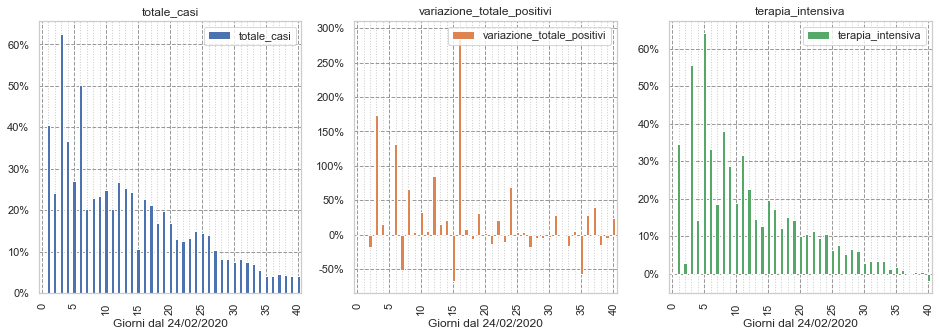

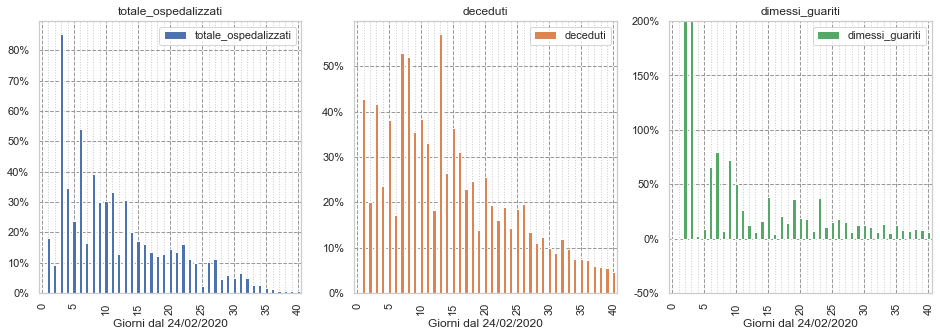

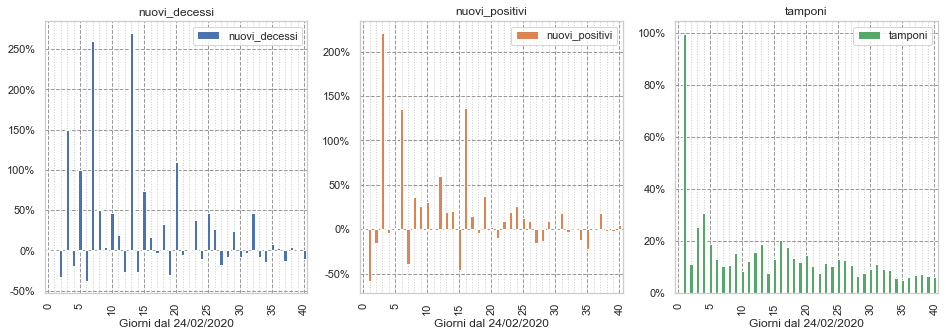

In [47]:
tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(x, '.0%'))
xtick = matplotlib.ticker.FuncFormatter(lambda x, p: format(x, '.0f'))
plt.rcParams['figure.figsize'] = [16, 5]

def plot_func(columns):
    global log_scale
    plot_pct = data_pct.loc[:,columns] \
        .plot(kind='bar',
              x='data',  
              subplots=True,
              sharex=True,
              layout=(1,3),
              grid=True,
              legend=True)
    plt_fmt = fmt_plot(plot_pct[0][0], .5)
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)
    plt_fmt = fmt_plot(plot_pct[0][1], .5)
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)
    plt_fmt = fmt_plot(plot_pct[0][2], .5)
    plt_fmt.yaxis.set_major_formatter(tick)
    plt_fmt.xaxis.set_major_formatter(xtick)

    return plot_pct

plot_pct = plot_func(['data','totale_casi','variazione_totale_positivi','terapia_intensiva'])
plot_pct = plot_func(['data','totale_ospedalizzati','deceduti','dimessi_guariti'])
plot_pct[0][2].set_ylim([-0.5,2])
plot_pct = plot_func(['data','nuovi_decessi','nuovi_positivi','tamponi'])


In [48]:
x = data.index
# y = data.totale_casi
# def exponential_model(x,a,b,c):
#     return a * np.exp(-b * x) + c
# transformer = FunctionTransformer(np.log, validate=True)

# Exponential fit regression
# x_reshaped = x.values.reshape(-1,1)
# y_reshaped = y.values.reshape(-1,1)
# y_trans = transformer.fit_transform(y_reshaped)
pred_x = np.linspace(0, days_range, days_range)
# pred_x_reshape = pred_x.reshape(-1,1)
# model = LinearRegression().fit(x_reshaped, y_trans)     
# y_fit = model.predict(pred_x_reshape)


## Regressione polinomiale, grado = 4

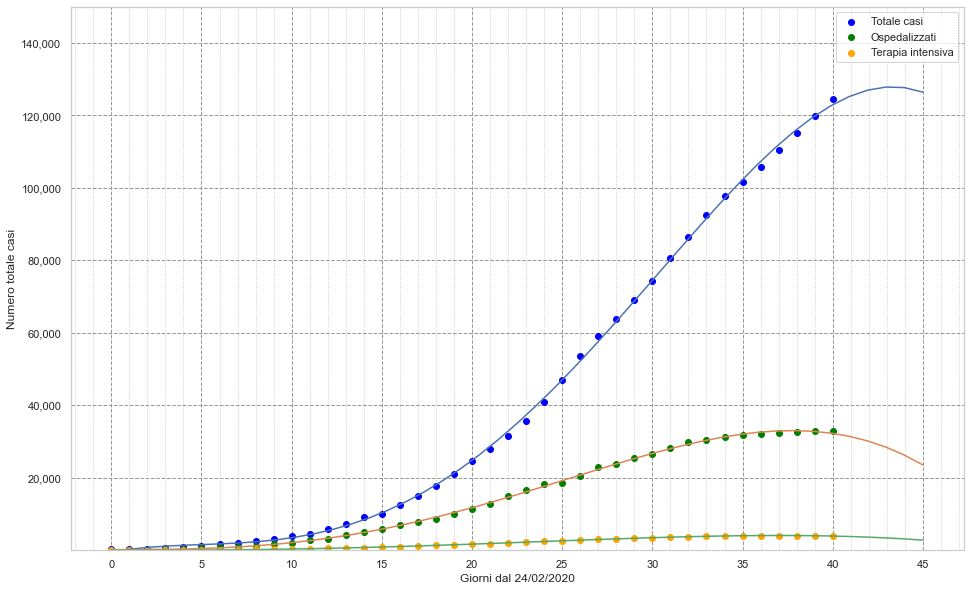

In [49]:
sns.set(style='whitegrid')
tick = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.rcParams['figure.figsize'] = [16, 10]
# plt.semilogy()

fmt_plot(plt.gca(), 20000)
plt.ylabel("Numero totale casi")
plt.ylim(1, 150000)

# Regression analysis
coefficients = np.polyfit(x.values, data.totale_casi.values, order)
poly = np.poly1d(coefficients)
coefficients2 = np.polyfit(x.values, data.totale_ospedalizzati.values, order)
poly2 = np.poly1d(coefficients2)
coefficients3 = np.polyfit(x.values, data.terapia_intensiva.values, order)
poly3 = np.poly1d(coefficients3)

plt_scatter = plt.scatter(x,data.totale_casi,label="Totale casi", color="blue")
plt_scatter2 = plt.scatter(x,data.totale_ospedalizzati, label="Ospedalizzati", color="green")
plt_scatter3 = plt.scatter(x,data.terapia_intensiva, label="Terapia intensiva", color="orange")
# plt_exp = plt.plot(pred_x, np.exp(y_fit), label="Regressione esponenziale")
plt_poly = plt.plot(pred_x, poly(pred_x))
plt_poly2 = plt.plot(pred_x, poly2(pred_x))
plt_poly3 = plt.plot(pred_x, poly3(pred_x))

legend = plt.legend()
